# **Exercise 1**: Run your first SFINCS model for Charleston

In this exercise we will run an existing SFINCS model for the area around Charleston. 
Afterwards you will analyse the results in the next notebook.
After doing this exercise you will know how to run a SFINCS model. 

We use the **HydroMT-SFINCS** python package to build and inspect SFINCS models from python. 
Note that this python package does not include the SFINCS software itself to perform the hydrodynamic simulations, this is installed separately in step 4. 

We will follow the following steps to inspect and run the model:

- Step 1: Load existing model
- Step 2: Visualize model
- Step 3: Inspect the SFINCS input (settings) file
- Step 4: Inspect the model components
- Step 5: Install & run SFINCS model

## Import dependencies

Before anything else we need to import the required packages, these should be installed in your python environment.

In [2]:
from pathlib import Path
import sys

import hydromt
import hydromt_sfincs

from hydromt_sfincs import SfincsModel

# local script imports
from sfincs_utils import run_sfincs

Check version of hydromt_sfincs

In [3]:
# NOTE you need at least version >=0.10
print("HydroMT core version", hydromt.__version__)

# NOTE you need at least version >=1.1.0
print("HydroMT-SFINCS version", hydromt_sfincs.__version__)

HydroMT core version 0.10.1
HydroMT-SFINCS version 1.2.1


## **Step 1:** Load existing model

The first step is to load the existing model results by providing:
 - `root_folder`: Folder where the model was saved. Path is relative to current working directory. We are loading in the model **sfincs_charleston_hugo**

In [4]:
# note, the "../" indicates a relative path one level up from the current notebook, the resolve method makes is an absolute path
# make sure this path is correct for your setup
root_folder  = Path(r'../models/sfincs_charleston_hugo').resolve()
print(f"Reading model from {root_folder}")

sf = SfincsModel(root=root_folder, mode='r')
sf.read()

Reading model from C:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_charleston_hugo


## **Step 2:** Visualise model
Now we use the HydroMT function `plot_basemap` to get a quick idea what the model looks like.
We plot the elevation of the model 'dep', including more information on boundaries and observations points (more on that later during the course).

More information on the function plot_basemap can be found in the online documentation of HydroMT-SFINCS, in the [API reference](https://deltares.github.io/hydromt_sfincs/stable/_generated/hydromt_sfincs.SfincsModel.plot_basemap.html#hydromt_sfincs.SfincsModel.plot_basemap)

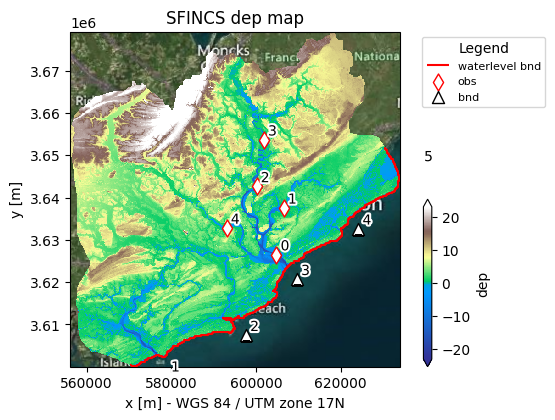

In [5]:
fig, ax = sf.plot_basemap(
    variable='dep', # plot the bed levels
    bmap='sat', # use satellite background
)


## **Step 3:** Inspect the SFINCS input (settings) file

A SFINCS model is configured using a text file, the `sfincs.inp` file, with various settings and references to input files. A SFINCS model instance consist of all files referenced in the input file. The name of this input file `sfincs.inp` is fixed, as are the names of the output files `sfincs_map.nc` (gridded outputs) and `sfincs_his.nc` (point or cross-section time series output) which are stored in the same folder as the input file.

A brief overview of available settings (link to the docs for more info): 

| property | description | settings | docs |
| ---------| ----------- | -------- | ---- | 
| model grid | Defines grid and geosptatial location. | `mmax`, `nmax`, `dx`, `dy`, `x0`, `y0`, `rotation`, `epsg`, `latitute`, `utmzone` | [link](https://sfincs.readthedocs.io/en/latest/input.html#grid-characteristics) | |
| cell functions | Defines (in)active and boundary cells. | `mskfile`, `indexfile` | [link](https://sfincs.readthedocs.io/en/latest/input.html#mask-file) |
| time management | Input, start, stop end output times. | `tref`, `tstart`, `tstop`, `dtout`, `dthisout`, `dtmaxout` | [link](https://sfincs.readthedocs.io/en/latest/input.html#time-management) |
| numerical parameters | Settings for numerical solver. | `alpha`, `huthresh`,  `theta`, `advection`, `advlim`,... | [link](https://sfincs.readthedocs.io/en/latest/input.html#numerical-parameters) |
| model output | Optional model timeseries output | `obsfile` (point water level timeseries), `crsfile` (cross section discharge time series) | [link](https://sfincs.readthedocs.io/en/latest/input.html#observation-points) |
| grid bedlevel & friction | Cell average bedlevel and friction. | `depfile`, `manning` (constant), `manning_land`, `manning_sea`, and `rgh_lev_land` (constants for land and sea), `maningfile` (spatially distributed) | [link bedlevel](https://sfincs.readthedocs.io/en/latest/input.html#depth-file), [link friction](https://sfincs.readthedocs.io/en/latest/input.html#friction)
| subgrid bedlevel & friction | Subgrid bed level and friction variation. Note: Use instead of cell average roughness and bedlevel settings. | `sbgfile` (pre-processed tables to account for) | [link](https://sfincs.readthedocs.io/en/latest/input.html#subgrid-tables) |
| infiltration | Proportion of rainfall that is absorbed into the soil. Note: Infiltration is only turned on when rainfall is forced. | `qinf` (constant rate), `qinffile` (spatially varying constant rate), ..., Curve-Number, GreenAmpt, and Horton. | [link](https://sfincs.readthedocs.io/en/latest/input.html#infiltration)
| water level forcing | Waterlevel [m] locations and time series. | `bndfile`, `bzsfile` | [link](https://sfincs.readthedocs.io/en/latest/input_forcing.html#water-levels) |
| discharge forcing | discharge [m3/s] source locations and time series |`srcfile`, `disfile` | [link](https://sfincs.readthedocs.io/en/latest/input_forcing.html#discharges) |
| rainfall forcing | rainfall [mm/hr] | `precipfile` (spatially uniform), `amprfile` (spatially distributed) | [link](https://sfincs.readthedocs.io/en/latest/input_forcing.html#) |
| intitial conditions | Initial conditions. | `zsini` (sptially uniform waterlevel), `rstfile` (restart file including levels and fluxes) | [link](https://sfincs.readthedocs.io/en/latest/input.html#restart-file) |



In [6]:
# let's inspect the model configuration using the `SfincsModel.config` property 
# (you can also open the <model_root>/sfincs.inp file in a text editor)
sf.config

{'mmax': 388,
 'nmax': 394,
 'dx': 200,
 'dy': 200,
 'x0': 556284.0,
 'y0': 3600208.0,
 'rotation': 0,
 'epsg': 32617,
 'latitude': 0.0,
 'tref': datetime.datetime(1989, 9, 10, 12, 0),
 'tstart': datetime.datetime(1989, 9, 21, 0, 0),
 'tstop': datetime.datetime(1989, 9, 22, 12, 0),
 'tspinup': 60.0,
 'dtout': 3600,
 'dthisout': 600,
 'dtrstout': 0.0,
 'dtmaxout': 864000,
 'trstout': -999.0,
 'dtwnd': 1800.0,
 'alpha': 0.5,
 'theta': 1.0,
 'huthresh': 0.01,
 'manning': 0.04,
 'zsini': -0.5,
 'qinf': 0.0,
 'rhoa': 1.25,
 'rhow': 1024.0,
 'dtmax': 60.0,
 'advection': 1,
 'stopdepth': 100.0,
 'viscosity': 1,
 'mskfile': 'sfincs.msk',
 'indexfile': 'sfincs.ind',
 'bndfile': 'sfincs.bnd',
 'bzsfile': 'sfincs.bzs',
 'sbgfile': 'sfincs_subgrid.nc',
 'obsfile': 'sfincs.obs',
 'inputformat': 'bin',
 'outputformat': 'net'}

### **Question 1 Understand the settings file**

1a) What is the model resolution?

1b) How long is the simulation period (in hours)?

1c) Besides the sfincs.inp, which files are all included in the model?



#### Fill in your own answers:

1a) xy
200x200

1b) tstop - tstart
datetime.datetime(1989, 9, 22, 12, 0) - datetime.datetime(1989, 9, 21, 0, 0)
format YYYY, M, DD, HH, m
simulation period is 12 hours

1c) Subgrid, forcing and numerical parameters

## **Step 4**: Inspect the model components

The SFINCS model is represented by HydroMT-SFINCS with the following data model components: `grid`, `geoms`, `forcing`, `subgrid`, `states`. Each of these components may contain some of the model input variables. The `grid` contains all variables which are defined on the grid, such as the mask `"msk"` and topobathy `"dep"`. The `forcing` contains all hydro-meteorological forcing variables, such as waterlevel forcing `"bzs"`, discharge forcing `"dis"` and uniform rainfall `"precip"`. For a full overview of the model components and the variables stored on each component, see [HydroMT-SFINCS user guide](https://deltares.github.io/hydromt_sfincs/stable/user_guide/sfincs_model_setup.html). Note that we use the latest stable release **v1.2.1** of HydroMT-SFINCS. If you google for HydroMT-SFINCS documentation you may find the latest or development version, which has undergone some major changes compared to the stable release. Make sure to use the stable release documentation for this course which can be recognized by the `stable` or `v1.2.1` in the URL.

### **Question 2 Understand the SFINCS model components**

Inspect the different model components the to answer the questions below.

2a) Which grid variables are set in this model?

2b) Which forcing variables are set in this model?

2c) How many water level points are set in the model? (hint: look at the *index* dimension)


#### Fill in your own answers:

2a)

2b)

2c)

In [7]:
## Inspect the model components

sf.grid

<xarray.Dataset> Size: 1MB
Dimensions:      (y: 394, x: 388)
Coordinates:
  * y            (y) float64 3kB 3.6e+06 3.601e+06 ... 3.679e+06 3.679e+06
  * x            (x) float64 3kB 5.564e+05 5.566e+05 ... 6.336e+05 6.338e+05
    spatial_ref  int64 8B 0
Data variables:
    msk          (y, x) uint8 153kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dep          (y, x) float32 611kB nan nan nan nan nan ... nan nan nan nan
    manning      (y, x) float32 611kB nan nan nan nan nan ... nan nan nan nan
Attributes:
    _FillValue:  0

## **Step 5:** Install SFINCS software and run SFINCS model

If you're on **Windows**, you can use the executable in the "../software" folder.
By using the executable we you agree to the [license agreement of SFINCS](https://github.com/Deltares/SFINCS/blob/main/LICENSE)
Note that for any use outside of this course, you should download the latest official SFINCS release from [here](https://download.deltares.nl/sfincs)

On **Linux** or **MacOS**, you can install [Docker Desktop](https://www.docker.com/products/docker-desktop/) or [Apptainer](https://apptainer.org/docs/admin/main/installation.html#) to use the  containerized version of SFINCS. Note that a docker image is automatically downloaded at first use which may take some time. 

Now we can run your SFINCS model!

We have prepared a small python function to run the model using either the window SFINCS executable or docker or apptainer SFINCS container. 
The function basically calls the executable from the SFINCS model folder (for windows executable) or the container software with the right arguments (for docker or apptainer).
This command will be printed when you use the function. 



In [8]:
# checkout options of the run_sfincs function
# you can find alternative methods
?run_sfincs

Signature:
run_sfincs(
    sfincs_inp: pathlib._local.Path,
    run_method: Literal['exe', 'docker', 'apptainer'],
    sfincs_exe: Optional[pathlib._local.Path] = None,
    docker_tag: str = 'sfincs-v2.1.1-Dollerup-Release',
    verbose: bool = True,
) -> None
Docstring:
Run the SfincsRun method.

Parameters
----------
sfincs_inp : Path
    The path to the SFINCS model configuration (inp) file.
run_method : Literal["exe", "docker", "apptainer"]
    How to run the SFINCS model. The default is "exe", which runs the Windows executable.
    If 'docker' or 'aptainer' is specified, the model is run in a Docker or Apptainer container.
sfincs_exe : Optional[Path], optional
    The path to SFINCS executable, by default None.
    Required if run_method == "exe".
docker_tag : str, optional
    The Docker tag to specify the version of the Docker image to use, by default "sfincs-v2.1.1-Dollerup-Release".
verbose : bool, optional
    Print output to screen, by default True.
File:      c:\users\sanne

In [9]:

sfincs_exe = Path(r"../software/SFINCS_v2.1.1/sfincs.exe").resolve()

run_sfincs(
    Path(root_folder, "sfincs.inp"), # path to the SFINCS model root folder
    run_method="exe", # run SFINCS using the executable, other options are "docker" or "singularity"
    sfincs_exe=sfincs_exe, # path to the sfincs executable if you want to run SFINCS on windows
)


Running SFINCS model in C:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_charleston_hugo with command:
>> C:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\software\sfincs_v2.1.1\sfincs.exe

 -----------------------------------------

 Build-Revision: $Rev: v2.1.1-Dollerup
 Build-Date:     $Date: 2024-08-28

 Reading input file ...
 Info : Running SFINCS in subgrid mode ...
 Turning on process: Viscosity
 Advection scheme : First-order upwind
 Reading meteo data ...
 Info : Preparing SFINCS grid on regular mesh ...
 Reading index file : sfincs.ind ...
 Reading mask file : sfincs.msk ...
 Number of active z points    :        97508
 Number of active u/v points  :       194081
 Viscosity - nuvisc  =    2.000000    
 Reading sub-grid netCDF file ...
 Number of subgrid levels :           10
 Reading water level boundaries ...
 Reading observation points ...
 Initializing output ...

 ---------- Starting simulation ----------
 ---- Using 24 of 24 avail

### **Question 3 Understand the log file**

3a) Did your simulation finish successfully?

3b) Which model version are you using?

3c) How long did it take to run the model?

3d) Can you find how many active grid cells the model has? 

#### Fill in your own answers:

3a)

3b)

3c)

3d)

## **Done**

Congrats, you ran your first SFINCS model!

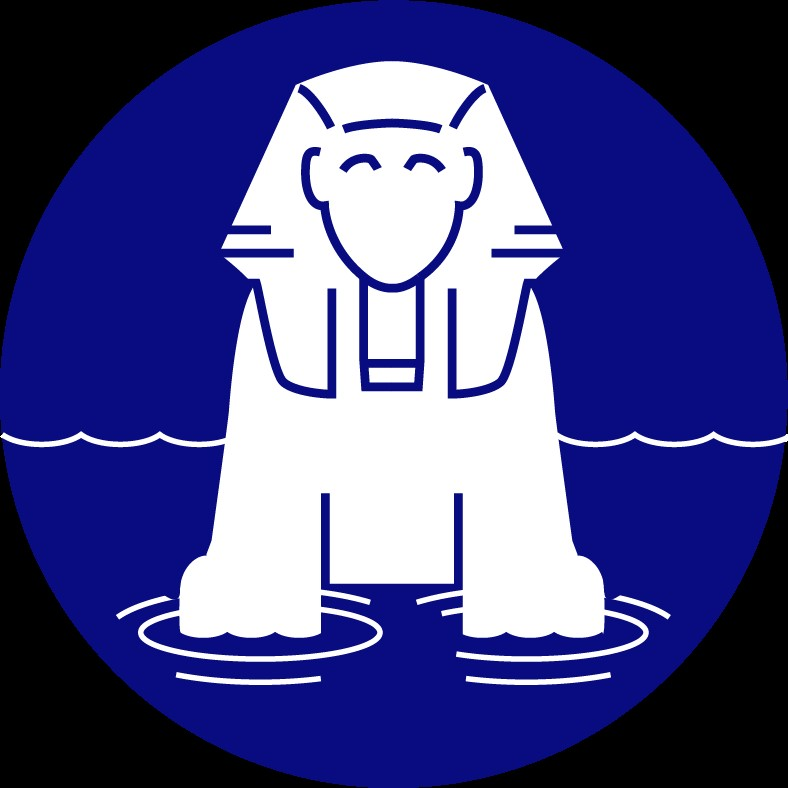